In [384]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [385]:
def rotate_point(origin, point, angle):

    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)

    return int(qx), int(qy)

# Node detection kernel, generates feature to detect inside sliding window
def generate_features(win, feature, angle=0, thickness=1):

    # Check that feature is correctly specified
    assert feature in ("cross", "tee", "elbow", "end"), "Feature must be one of 'cross', 'tee', 'elbow', or 'end'."

    # Convert angle to radians
    angle = np.deg2rad(angle)
    
    # Create kernel matrix, if end feature is selected, generate end-detector mask
    kernel = np.zeros((win, win), np.uint8)
    if feature == "end":
        end_mask = np.zeros((win, win), np.uint8)

    # Define center of kernel
    center = win // 2
    origin = (center, center)

    # Draw Top
    if feature in ("cross", "tee", "end"):
        endpoint = rotate_point(origin, (center, 1), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Bottom
    if feature == "cross":
        endpoint = rotate_point(origin, (center, win-1), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Left 
    if feature in ("cross", "tee"):
        endpoint = rotate_point(origin, (1, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw Right 
    if feature in ("cross", "tee", "elbow"):
        endpoint = rotate_point(origin, (win-1, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Draw end mask, if applicable
    if feature == "end":
        edge_detector_1 = rotate_point(origin, (center-win//4, win-win//4), angle)
        edge_detector_2 = rotate_point(origin, (center+win//4, win-win//4), angle)
        edge_detector_3 = rotate_point(origin, (center, win-win//2.5), angle)
        cv2.line(end_mask, edge_detector_1, edge_detector_1, (1, 1, 1), thickness)
        cv2.line(end_mask, edge_detector_2, edge_detector_2, (1, 1, 1), thickness)
        cv2.line(end_mask, edge_detector_3, edge_detector_3, (1, 1, 1), thickness)
        
        
    if feature == "end":
        return kernel, end_mask + kernel
    else:
        return kernel

In [386]:
window = 35
radius = -(-window//2)

In [387]:
end_seg, end_mask = generate_features(window, feature="end", angle=60)

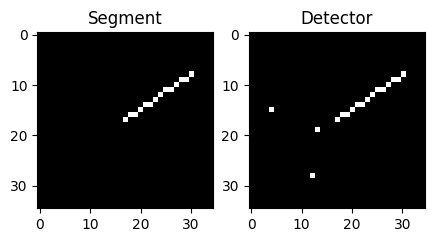

In [388]:
# Visualize end segment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))

ax1.imshow(end_seg, cmap='gray')
ax2.imshow(end_mask, cmap='gray')

# Optionally, set titles for each subplot
ax1.set_title('Segment')
ax2.set_title('Detector')

# Show the plot
plt.show()

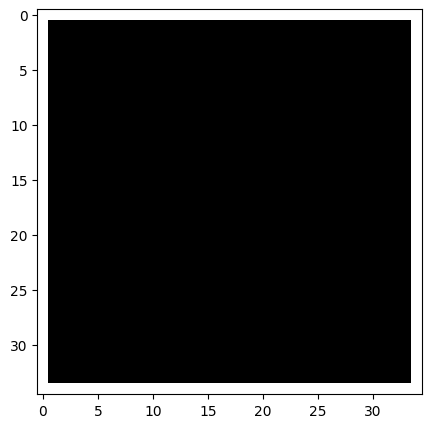

In [389]:
# Draw frame around window 
hit_perim = np.zeros((window, window), np.uint8)
hit_perim[0,:] = 1 # Top
hit_perim[:,0] = 1 # Left
hit_perim[window-1,:] = 1 # Bottom
hit_perim[:,window-1] = 1 # Right

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(hit_perim, cmap='gray')
